In [1]:
!pip install sklearn-pandas -q
!pip install torchvision -q
!pip install torchtuples -q
!pip install pycox -q
!pip install eli5 -q
!pip install lifelines -q

# Library import

In [26]:
import numpy as np
import torch
import torchtuples as tt
import seaborn as sns
import pandas as pd
import math, copy
import torch.nn as nn
import torch.nn.functional as F
from torchtuples.tupletree import tuplefy
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

from pycox.models import CoxPH
from pycox.evaluation.concordance import concordance_td
from pycox.evaluation import ipcw, admin
from pycox import utils

import matplotlib.pyplot as plt
from lifelines import *
from lifelines.utils import concordance_index
from operator import itemgetter

from typing import Tuple

import warnings
warnings.filterwarnings('ignore')

## Dataset

We load the METABRIC data set as a pandas DataFrame and split the data in in train, test and validation.

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

# Loading dataset and preprocessing it for further analysis

In [3]:
# Loading dataset with selected features
df_all = pd.read_csv('Metabric_selected.csv')
df_all.drop('Unnamed: 0', inplace=True, axis=1)

In [4]:
# Define categorical features. Needed for preprocessing
categories = pd.Index(['cellularity',
 'neoplasm_histologic_grade'])

In [5]:
def preprocess_dataset(data, data_train, num_cols, cat_cols):
    '''
        Function for dataset preprocessing
        arguments: data - dataset, data_train - data for scaling fit, num_cols - numerical features, cat_cols - categorical columns
        output: preprocessed dataset
    '''
    scaler = StandardScaler()
    scaler.fit(data_train[num_cols])
    standardize = [([col], scaler) for col in num_cols]
    x_mapper = DataFrameMapper(standardize)
    input_x_num = x_mapper.fit_transform(data).astype('float32')
    input_ids = np.zeros([input_x_num.shape[0], len(cat_cols)])
    vocab_size = 0
    for i,feat in enumerate(cat_cols):
        input_ids[:,i] = LabelEncoder().fit_transform(data[feat]).astype('float32') + vocab_size
        vocab_size += data[feat].max() + 1
    return np.concatenate((input_ids, input_x_num), axis=1), vocab_size

## Class with evaluation functions from pycox

In [27]:
class EvalSurv:

    def __init__(self, surv, durations, events, censor_surv=None, censor_durations=None, steps='post'):
        '''
            Class for calculating metrics for survival analysis.
            arguments: surv - predicted values, durations - durations feature (in months), events - events feature (bool), censor_curv and censor_durations - apply censoring
            output: metrics
        '''
        assert (type(durations) == type(events) == np.ndarray), 'Need `durations` and `events` to be arrays'
        self.surv = surv
        self.durations = durations
        self.events = events
        self.censor_surv = censor_surv
        self.censor_durations = censor_durations
        self.steps = steps
        assert pd.Series(self.index_surv).is_monotonic_increasing

    @property
    def censor_surv(self):
        """Estimated survival for censorings.
        Also an EvalSurv object.
        """
        return self._censor_surv

    @censor_surv.setter
    def censor_surv(self, censor_surv):
        if isinstance(censor_surv, EvalSurv):
            self._censor_surv = censor_surv
        elif type(censor_surv) is str:
            if censor_surv == 'km':
                self.add_km_censor()
            else:
                raise ValueError(f"censor_surv cannot be {censor_surv}. Use e.g. 'km'")
        elif censor_surv is not None:
            self.add_censor_est(censor_surv)
        else:
            self._censor_surv = None

    @property
    def index_surv(self):
        return self.surv.index.values

    @property
    def steps(self):

        return self._steps

    @steps.setter
    def steps(self, steps):
        vals = ['post', 'pre']
        if steps not in vals:
            raise ValueError(f"`steps` needs to be {vals}, got {steps}")
        self._steps = steps

    def add_censor_est(self, censor_surv, steps='post'):

        if not isinstance(censor_surv, EvalSurv):
            censor_surv = self._constructor(censor_surv, self.durations, 1-self.events, None,
                                            steps=steps)
        self.censor_surv = censor_surv
        return self

    def add_km_censor(self, steps='post'):

        km = utils.kaplan_meier(self.durations, 1-self.events)
        surv = pd.DataFrame(np.repeat(km.values.reshape(-1, 1), len(self.durations), axis=1),
                            index=km.index)
        return self.add_censor_est(surv, steps)

    @property
    def censor_durations(self):
        """Administrative censoring times."""
        return self._censor_durations

    @censor_durations.setter
    def censor_durations(self, val):
        if val is not None:
            assert (self.durations[self.events == 0] == val[self.events == 0]).all(),\
                'Censored observations need same `durations` and `censor_durations`'
            assert (self.durations[self.events == 1] <= val[self.events == 1]).all(),\
                '`durations` cannot be larger than `censor_durations`'
            if (self.durations == val).all():
                warnings.warn("`censor_durations` are equal to `durations`." +
                              " `censor_durations` are likely wrong!")
            self._censor_durations = val
        else:
            self._censor_durations = val

    @property
    def _constructor(self):
        return EvalSurv

    def __getitem__(self, index):
        if not (hasattr(index, '__iter__') or type(index) is slice) :
            index = [index]
        surv = self.surv.iloc[:, index]
        durations = self.durations[index]
        events = self.events[index]
        new = self._constructor(surv, durations, events, None, steps=self.steps)
        if self.censor_surv is not None:
            new.censor_surv = self.censor_surv[index]
        return new

    def plot_surv(self, **kwargs):

        if len(self.durations) > 50:
            raise RuntimeError("We don't allow to plot more than 50 lines. Use e.g. `ev[1:5].plot()`")
        if 'drawstyle' in kwargs:
            raise RuntimeError(f"`drawstyle` is set by `self.steps`. Remove from **kwargs")
        return self.surv.plot(drawstyle=f"steps-{self.steps}", **kwargs)

    def idx_at_times(self, times):

        return utils.idx_at_times(self.index_surv, times, self.steps)

    def _duration_idx(self):
        return self.idx_at_times(self.durations)

    def surv_at_times(self, times):
        idx = self.idx_at_times(times)
        return self.surv.iloc[idx]

    def concordance_td(self, method='adj_antolini'):

        return concordance_td(self.durations, self.events, self.surv.values,
                              self._duration_idx(), method)

    def brier_score(self, time_grid, max_weight=np.inf):

        if self.censor_surv is None:
            raise ValueError("""Need to add censor_surv to compute Brier score. Use 'add_censor_est'
            or 'add_km_censor' for Kaplan-Meier""")
        bs = ipcw.brier_score(time_grid, self.durations, self.events, self.surv.values,
                              self.censor_surv.surv.values, self.index_surv,
                              self.censor_surv.index_surv, max_weight, True, self.steps,
                              self.censor_surv.steps)
        return pd.Series(bs, index=time_grid).rename('brier_score')


    def integrated_brier_score(self, time_grid, max_weight=np.inf):

        if self.censor_surv is None:
            raise ValueError("Need to add censor_surv to compute briser score. Use 'add_censor_est'")
        return ipcw.integrated_brier_score(time_grid, self.durations, self.events, self.surv.values,
                                           self.censor_surv.surv.values, self.index_surv,
                                           self.censor_surv.index_surv, max_weight, self.steps,
                                           self.censor_surv.steps)


    def brier_score_admin(self, time_grid):

        if self.censor_durations is None:
            raise ValueError("Need to provide `censor_durations` (censoring durations) to use this method")
        bs = admin.brier_score(time_grid, self.durations, self.censor_durations, self.events,
                               self.surv.values, self.index_surv, True, self.steps)
        return pd.Series(bs, index=time_grid).rename('brier_score')

    def integrated_brier_score_admin(self, time_grid):

        if self.censor_durations is None:
            raise ValueError("Need to provide `censor_durations` (censoring durations) to use this method")
        ibs = admin.integrated_brier_score(time_grid, self.durations, self.censor_durations, self.events,
                                           self.surv.values, self.index_surv, self.steps)
        return ibs


# 1) Baseline model

In [7]:
class MLPBlock(nn.Module):
    def __init__(self, in_features, out_features, bias=True, batch_norm=False, dropout=0., activation=nn.ReLU,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu')):
        '''
            Basic MLP block with batchnorm, dropout and weight initialization.
            arguments: in_features, out_features - input and output shapes, bias, batchnorm - include bias, batchnorm, dropout - dropout prob, activation - act. function, w_init - type of weight initialization
        '''
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)
        self.activation = activation()
        self.batch_norm = nn.BatchNorm1d(out_features) if batch_norm else None
        self.dropout = nn.Dropout(dropout) if dropout else None

    def forward(self, input):
        input = self.activation(self.linear(input))
        if self.batch_norm:
            input = self.batch_norm(input)
        if self.dropout:
            input = self.dropout(input)
        return input



class MLP(nn.Module):
    def __init__(self, in_features, num_nodes, out_features, batch_norm=False, dropout=None, activation=nn.ReLU,
                 output_activation=None, output_bias=True,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu')):
        '''
            MLP constructed from MLP blocks.
            arguments: num_nodes = list of hidden dimentions, rest is like in MLPBlock
        '''
        super().__init__()
        num_nodes = tuplefy(in_features, num_nodes).flatten()
        dropout = [dropout for _ in range(len(num_nodes)-1)]
        net = []
        for n_in, n_out, p in zip(num_nodes[:-1], num_nodes[1:], dropout):
            net.append(MLPBlock(n_in, n_out, True, batch_norm, p, activation, w_init_))
        net.append(nn.Linear(num_nodes[-1], out_features, output_bias))
        if output_activation:
            net.append(output_activation)
        self.net = nn.Sequential(*net)

    def forward(self, input):
        return self.net(input)

In [8]:
def BaselineCoxPH(df_all, num_et):

    '''
        Baseline model for survival prediction (DeepSurv).
        arguments: df_all - dataframe with all observations, num_et - iterations
        output: concordance on test and train, brier score on test
    '''

    concordance_test = []
    concordance_train = []
    brier_test  = []


    for rs in (range(num_et)):


        df_train, df_temp = train_test_split(df_all, train_size=0.65, stratify =df_all['chemotherapy'], random_state=rs)
        df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify =df_temp['chemotherapy'], random_state=rs)


        final_columns = list(np.setdiff1d(df_train.columns, ["event", "overall_survival_months"]))
        leave = [(col, None) for col in final_columns]

        x_mapper = DataFrameMapper(leave)

        x_train = x_mapper.fit_transform(df_train).astype('float32')
        x_val = x_mapper.transform(df_val).astype('float32')
        x_test = x_mapper.transform(df_test).astype('float32')



        EVENT_TIME =  "overall_survival_months"
        EVENT = "event"


        get_target = lambda df: (df[EVENT_TIME].values, df[EVENT].values)
        y_train = get_target(df_train)
        y_val = get_target(df_val)
        durations_test, events_test = get_target(df_test)
        val = x_val, y_val

        #
        durations_train, events_train = get_target(df_train)


        in_features = x_train.shape[1]
        num_nodes = [50, 50]
        out_features = 1
        batch_norm = False
        dropout = 0.2
        output_bias = False

        net = MLP(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)

        optimizer = tt.optim.Adam(0.01)
        model = CoxPH(net, optimizer)

        model.optimizer.set_lr(0.05)
        epochs = 512
        batch_size=256
        callbacks = [tt.callbacks.EarlyStopping()]
        verbose = True

        log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data=val, val_batch_size=batch_size)




        _ = model.compute_baseline_hazards()

        surv = model.predict_surv_df(x_test)
        surv_train = model.predict_surv_df(x_train)

        ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
        ev_train = EvalSurv(surv_train , durations_train , events_train , censor_surv='km')

        lower, upper = np.percentile(durations_test, [10, 90])
        time_grid = np.arange(lower, upper + 1)

        concordance_test.append(ev.concordance_td('antolini'))
        concordance_train.append(ev_train.concordance_td('antolini'))
        brier_test.append(ev.integrated_brier_score(time_grid))

    return concordance_test, concordance_train, brier_test

## Baseline model evaluation

In [90]:
num_et = 10
C_test = {}
B_test = {}


concordance_test, concordance_train, brier_test = BaselineCoxPH(df_all, num_et)
C_test["Base"]= np.array(concordance_test)
B_test["Base"]= np.array(brier_test)

0:	[0s / 0s],		train_loss: 22.5950,	val_loss: 5.1057
1:	[0s / 0s],		train_loss: 7.9038,	val_loss: 4.9147
2:	[0s / 0s],		train_loss: 5.5986,	val_loss: 4.7894
3:	[0s / 0s],		train_loss: 5.3632,	val_loss: 4.5081
4:	[0s / 0s],		train_loss: 5.1554,	val_loss: 4.4426
5:	[0s / 0s],		train_loss: 5.0097,	val_loss: 4.4334
6:	[0s / 0s],		train_loss: 5.0055,	val_loss: 4.4332
7:	[0s / 0s],		train_loss: 4.9875,	val_loss: 4.4315
8:	[0s / 0s],		train_loss: 5.0068,	val_loss: 4.4272
9:	[0s / 0s],		train_loss: 4.9846,	val_loss: 4.4146
10:	[0s / 0s],		train_loss: 4.9875,	val_loss: 4.4094
11:	[0s / 0s],		train_loss: 4.9832,	val_loss: 4.4062
12:	[0s / 0s],		train_loss: 4.9590,	val_loss: 4.3980
13:	[0s / 0s],		train_loss: 4.9903,	val_loss: 4.3953
14:	[0s / 0s],		train_loss: 4.9529,	val_loss: 4.3954
15:	[0s / 0s],		train_loss: 4.9475,	val_loss: 4.3915
16:	[0s / 0s],		train_loss: 4.9234,	val_loss: 4.3898
17:	[0s / 0s],		train_loss: 4.9080,	val_loss: 4.3963
18:	[0s / 0s],		train_loss: 4.9457,	val_loss: 4.3932
19

# 2) Model from the article with open code (sa_transformer)

In [91]:
#parameters of a model

max_time = 400
pred_method = 'mean'
lr = 2e-6
coeff = 1
coeff2 = 1
num_heads = 4
d_ff = 2048
d_model = 512
drop_prob = 0.1
train_batch_size = 16
num_epochs = 5
N = 4
data_parallel = True

class TranDataset(Dataset):
    def __init__(self, features, labels, is_train=True):
        '''
            Class for dataset creation.
            arguments: features, labels, is_train - create train or test
        '''
        self.is_train = is_train
        self.data = []

        temp = []
        for feature, label in zip(features, labels):
            feature = torch.from_numpy(feature).float()
            duration, is_observed = int(label[0] // 1), label[1]
            temp.append([duration, is_observed, feature])
        sorted_temp = sorted(temp, key=itemgetter(0))

        if self.is_train:
            new_temp = sorted_temp
        else:
            new_temp = temp



        for duration, is_observed, feature in new_temp:
            if is_observed:
                mask = max_time * [1.]
                label = duration * [1.] + (max_time - duration) * [0.]
                feature = torch.stack(max_time * [feature])
                self.data.append([feature, torch.tensor(duration).float(), torch.tensor(mask).float(), torch.tensor(label), torch.tensor(is_observed).byte()])
                # print(torch.tensor(is_observed).byte().cuda())
            else:
                # NOTE plus 1 to include day 0
                mask = (duration + 1) * [1.] + (max_time - (duration + 1)) * [0.]
                label = max_time * [1.]
                feature = torch.stack(max_time * [feature])
                self.data.append([feature, torch.tensor(duration).float(), torch.tensor(mask).float(), torch.tensor(label), torch.tensor(is_observed).byte()])

    def __getitem__(self, index_a):
        if self.is_train:
            if index_a == len(self.data) - 1:
                index_b = np.random.randint(len(self.data))
            else:
                # NOTE self.data is sorted
                index_b = np.random.randint(index_a+1, len(self.data))
            return [ [self.data[index_a][i], self.data[index_b][i]] for i in range(len(self.data[index_a])) ]
        else:
            return self.data[index_a]

        return self.data[index_a]

    def __len__(self):
        return len(self.data)


def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


def attention(query, key, value, mask=None, dropout=None):
    # Attention block
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        '''
            Class for multihead attention creation
        '''
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)
        nbatches = query.size(0)

        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        '''
            Position encding class
        '''
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -torch.tensor(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        '''
            Class for creation of feed forward layer after attention
        '''
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        '''
            Class for LayerNorm creation
        '''
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        '''
            Class for residual connection
        '''
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))


# Initial embedding for raw input
class SrcEmbed(nn.Module):
    def __init__(self, input_dim, d_model):
        super(SrcEmbed, self).__init__()
        self.w = nn.Linear(input_dim, d_model)
        self.norm = LayerNorm(d_model)

    def forward(self, x):
        return self.norm(self.w(x))


# Final layer for the Transformer
class TranFinalLayer(nn.Module):
    def __init__(self, d_model):
        super(TranFinalLayer, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model // 2)
        self.norm = LayerNorm(d_model // 2)
        self.w_2 = nn.Linear(d_model // 2, 1)

    def forward(self, x):
        x = F.relu(self.w_1(x))
        x = self.norm(x)
        x = self.w_2(x)
        return torch.sigmoid(x.squeeze(-1))


class Encoder(nn.Module):
    def __init__(self, layer, N, d_model, dropout, num_features):
        '''
            Class for encoder creation
        '''
        super(Encoder, self).__init__()
        self.src_embed = SrcEmbed(num_features, d_model)
        self.position_encode = PositionalEncoding(d_model, dropout)
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        self.final_layer = TranFinalLayer(d_model)

    def forward(self, x, mask=None):
        x = self.position_encode(self.src_embed(x))
        for layer in self.layers:
            x = layer(x, mask)
        return self.final_layer(x)


class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        '''
            Class for encoder layer initialization
        '''
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

# Evaluation loop
def evaluate(encoder, loader, train=False):
    '''
        Evaluation loop
        output: test concordance, test survival probabilities predicted
    '''
    encoder.eval()
    with torch.no_grad():
        pred_durations, true_durations, is_observed = [], [], []
        pred_obs_durations, true_obs_durations = [], []

        total_surv_probs = []

        # NOTE batch size is 1

        for features, durations, mask, label, is_observed_single in loader:
            is_observed.append(is_observed_single.cpu())
            sigmoid_preds = encoder.forward(features)
            surv_probs = torch.cumprod(sigmoid_preds, dim=1).squeeze()
            total_surv_probs.append(surv_probs)

            if pred_method == 'mean':
                pred_duration = torch.sum(surv_probs).item()
            elif pred_method == 'median':
                pred_duration = 0
                while True:
                    if surv_probs[pred_duration] < 0.5:
                        break
                    else:
                        pred_duration += 1
                        if pred_duration == len(surv_probs):
                            break

            true_duration = durations.squeeze().item()
            pred_durations.append(pred_duration)
            true_durations.append(true_duration)

            if is_observed_single:
                pred_obs_durations.append(pred_duration)
                true_obs_durations.append(true_duration)

        total_surv_probs = torch.stack(total_surv_probs)

        pred_obs_durations = np.asarray(pred_obs_durations)
        true_obs_durations = np.asarray(true_obs_durations)

        pred_durations = np.asarray(pred_durations)
        true_durations = np.asarray(true_durations)
        is_observed = np.asarray(is_observed, dtype=bool).squeeze()

        test_cindex = concordance_index(true_durations, pred_durations, is_observed)

    return test_cindex, total_surv_probs





def train(train_loader, val_loader, test_loader, features, labels, encoder):
    '''
        Train loop
    '''
    optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)

    for t in range(num_epochs):
        print('epoch', t)
        encoder.train()

        tot_loss = 0.
        for features, true_durations, mask, label, is_observed in train_loader:
            optimizer.zero_grad()

            is_observed_a = is_observed[0]
            mask_a = mask[0]
            mask_b = mask[1]
            label_a = label[0]
            label_b = label[1]
            true_durations_a = true_durations[0]
            true_durations_b = true_durations[1]

            sigmoid_a = encoder.forward(features[0])
            surv_probs_a = torch.cumprod(sigmoid_a, dim=1)
            loss = nn.BCELoss()(surv_probs_a * mask_a, label_a * mask_a)

            sigmoid_b = encoder.forward(features[1])
            surv_probs_b = torch.cumprod(sigmoid_b, dim=1)

            cond_a = is_observed_a & (true_durations_a < true_durations_b)
            if torch.sum(cond_a) > 0:
                mean_lifetimes_a = torch.sum(surv_probs_a, dim=1)
                mean_lifetimes_b = torch.sum(surv_probs_b, dim=1)
                diff = mean_lifetimes_b[cond_a] - mean_lifetimes_a[cond_a]
                true_diff = true_durations_b[cond_a] - true_durations_a[cond_a]
                loss += coeff * torch.mean(nn.ReLU()(true_diff - diff))

            cond_a2 = is_observed_a
            if torch.sum(cond_a2) > 0:
                mean_lifetimes_a = torch.sum(surv_probs_a, dim=1)
                loss += coeff2 * F.l1_loss(mean_lifetimes_a[cond_a2], true_durations_a[cond_a2])

            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
        print('train total loss', tot_loss)

        # Evaluate
        val_cindex, _ = evaluate(encoder, val_loader)
        print(f'Validation concordance: {val_cindex}')

In [92]:
def sa_transformer(df_all, num_et):

    '''
        Function for SA_Transformer training and testing.
        output: concordance on train and test, brier score for test
    '''
    concordance_test = []
    concordance_train = []
    brier_test  = []

    for rs in (range(num_et)):


        df_train, df_temp = train_test_split(df_all, train_size=0.65, stratify =df_all['chemotherapy'], random_state=rs)
        df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify =df_temp['chemotherapy'], random_state=rs)

        final_columns = list(np.setdiff1d(df_train.columns, ["event", "overall_survival_months", "nr2f1"]))
        leave = [(col, None) for col in final_columns]

        x_mapper = DataFrameMapper(leave)

        x_train = x_mapper.fit_transform(df_train).astype('float32')
        x_val = x_mapper.transform(df_val).astype('float32')
        x_test = x_mapper.transform(df_test).astype('float32')

        EVENT_TIME =  "overall_survival_months"
        EVENT = "event"

        get_target = lambda df: (df[EVENT_TIME].values, df[EVENT].values)
        y_train = np.array([[df_train[EVENT_TIME].iloc[i], df_train[EVENT].iloc[i]] for i in range(df_train.shape[0])])
        y_val = np.array([[df_val[EVENT_TIME].iloc[i], df_val[EVENT].iloc[i]] for i in range(df_val.shape[0])])
        y_test = np.array([[df_test[EVENT_TIME].iloc[i], df_test[EVENT].iloc[i]] for i in range(df_test.shape[0])])

        durations_train, events_train = get_target(df_train)
        durations_test, events_test = get_target(df_test)


        train_features = x_train
        val_features = x_val
        test_features = x_test
        features = [train_features, val_features, test_features]

        train_labels = y_train
        val_labels = y_val
        test_labels = y_test
        labels = [train_labels, val_labels, test_labels]

        num_features = train_features.shape[1]


        train_loader = DataLoader(TranDataset(features[0], labels[0], is_train=True), batch_size=train_batch_size, shuffle=True)
        val_loader = DataLoader(TranDataset(features[1], labels[1], is_train=False), batch_size=1, shuffle=False)
        test_loader = DataLoader(TranDataset(features[2], labels[2], is_train=False), batch_size=1, shuffle=False)
        # For concordance calculation train_loader must be changed to 1 batch
        train_loader_check = DataLoader(TranDataset(features[0], labels[0], is_train=False), batch_size=1, shuffle=False)


        c = copy.deepcopy
        attn = MultiHeadedAttention(num_heads, d_model, drop_prob)
        ff = PositionwiseFeedForward(d_model, d_ff, drop_prob)
        encoder_layer = EncoderLayer(d_model, c(attn), c(ff), drop_prob)
        encoder = Encoder(encoder_layer, N, d_model, drop_prob, num_features)
        encoder = torch.nn.DataParallel(encoder)
        train(train_loader, val_loader, test_loader, features, labels, encoder)


        _, test_total_surv_probs = evaluate(encoder, test_loader)
        _, train_total_surv_probs = evaluate(encoder, train_loader_check)

        ev = EvalSurv(pd.DataFrame(test_total_surv_probs.cpu().numpy()).transpose(), y_test[:,0], y_test[:,1], censor_surv='km')
        ev_train = EvalSurv(pd.DataFrame(train_total_surv_probs.cpu().numpy()).transpose(), y_train[:,0], y_train[:,1], censor_surv='km')

        lower, upper = np.percentile(y_test[:,0], [10, 90])
        time_grid = np.arange(lower, upper + 1)

        concordance_test.append(ev.concordance_td('antolini'))
        concordance_train.append(ev_train.concordance_td('antolini'))
        brier_test.append(ev.integrated_brier_score(time_grid))

    return concordance_test, concordance_train, brier_test

## SA Transformer evaluation

In [93]:
num_et = 10

concordance_test, concordance_train, brier_test =  sa_transformer(df_all, num_et)
C_test["Article"]= np.array(concordance_test)
B_test["Article"]= np.array(brier_test)

epoch 0
train total loss 12001.922462463379
Validation concordance: 0.6219653675933485
epoch 1


KeyboardInterrupt: 

# 3) Our model - based on CoxPH with Model Multihead and Residual

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Function to ensure all inputs are tuples
def tuplefy(*args):
    return tuple([arg if isinstance(arg, (tuple, list)) else (arg,) for arg in args])

class BertEmbeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_numerical_feature, max_position_embeddings):
        '''
            Class for embeddings initialization
            output: embeddings
        '''
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        self.num_embeddings = nn.Parameter(torch.randn(1, num_numerical_feature, hidden_size), requires_grad=True)
        self.num_numerical_feature = num_numerical_feature

    def forward(self, input):
        input_ids = input[:, :-self.num_numerical_feature].to(torch.int)
        inputs_embeds = self.word_embeddings(input_ids)

        position_ids = torch.arange(inputs_embeds.size(1), dtype=torch.long, device=input.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        position_embeds = self.position_embeddings(position_ids)

        input_x_num = input[:, -self.num_numerical_feature:]
        num_embeddings = torch.unsqueeze(input_x_num, 2) * self.num_embeddings

        embeddings = torch.cat([inputs_embeds, num_embeddings], axis=1)
        embeddings = embeddings.to(torch.float)
        return embeddings


class MultiHeadSelfAttentionLayer(nn.Module):
    def __init__(self, hidden_size, num_heads):
        '''
            Class for MultiHeadAttention.
            output: if extract_heatmap = True, returns attention weights
        '''
        super(MultiHeadSelfAttentionLayer, self).__init__()
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.head_dim = hidden_size // num_heads

        assert self.head_dim * num_heads == hidden_size, "hidden_size must be divisible by num_heads"

        self.key = nn.Linear(hidden_size, hidden_size)
        self.query = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, mask=None, extract_heatmap=False):
        batch_size = x.size(0)
        seq_length = x.size(1)

        keys = self.key(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        queries = self.query(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        values = self.value(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)

        if extract_heatmap:
            return attention_weights.detach().cpu().numpy()  # Extract attention weights for all examples in batch

        output = torch.matmul(attention_weights, values)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_length, self.hidden_size)

        output = self.out(output)
        return output, attention_weights


class ResidualMLPBlock(nn.Module):
    def __init__(self, in_features, out_features, bias=True, batch_norm=False, dropout=0., activation=nn.ReLU,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), batch_features=0):
        '''
            MLPBlock identical to previous in baseline model, but with residual connections
        '''
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)
        self.activation = activation()
        self.batch_norm = nn.BatchNorm1d(batch_features) if batch_norm else None
        self.dropout = nn.Dropout(dropout) if dropout else None
        self.residual = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, input):
        residual = self.residual(input)
        input = self.activation(self.linear(input))
        if self.batch_norm:
            input = self.batch_norm(input)
        if self.dropout:
            input = self.dropout(input)
        return input + residual

class MLPBlock2(nn.Module):
    def __init__(self, in_features, out_features, bias=True, batch_norm=False, dropout=0., activation=nn.ReLU,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), batch_features=0):
        '''
            MLP block without residual connections
        '''
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)
        self.activation = activation()
        self.batch_norm = nn.BatchNorm1d(batch_features) if batch_norm else None
        self.dropout = nn.Dropout(dropout) if dropout else None

    def forward(self, input):
        input = self.activation(self.linear(input))
        if self.batch_norm:
            input = self.batch_norm(input)
        if self.dropout:
            input = self.dropout(input)
        return input

class CLF(nn.Module):
    def __init__(self, in_features, out_features, num_features, bias=True, dropout = 0, activation=nn.ReLU,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu')):
        '''
            Final fc layer
        '''
        super().__init__()
        self.mlp = MLPBlock2(in_features * num_features, in_features, True, True, 0.2, activation, w_init_, in_features)
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)

    def forward(self, input):
        input = input.flatten(1)
        input = self.mlp(input)
        input = self.linear(input)
        return input

class MLP_with_attention(nn.Module):
    def __init__(self, num_heads, in_features, num_nodes, out_features, vocab_size, num_numerical_feature,num_features, batch_norm=False, dropout=None, activation=nn.ReLU,
                 output_activation=None, output_bias=True,
                 w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'), embed_dim=16, max_position_embeddings=512):
        '''
            Class for construction of SurvTrace model with MultiHeadAttention applied
        '''
        super().__init__()
        num_nodes_len = tuplefy(num_nodes)  # Correctly tuplefy `num_nodes`
        #dropout = [dropout for _ in range(len(num_nodes_len)-1)]
        net = []
        net.append(BertEmbeddings(vocab_size, embed_dim, num_numerical_feature, max_position_embeddings))
        net.append(MultiHeadSelfAttentionLayer(embed_dim, num_heads))
        net.append(nn.LayerNorm(embed_dim))
        # for i in range(len(num_nodes) - 1):
        net.append(ResidualMLPBlock(embed_dim, num_nodes[0], True, batch_norm, dropout, activation, w_init_, num_features))
        net.append(ResidualMLPBlock(num_nodes[0], num_nodes[1], True, batch_norm, dropout, activation, w_init_ , num_features))

        net.append(CLF(num_nodes[-1], out_features, num_features, output_bias, dropout))  # Last layer uses the last num_node value
        if output_activation:
            net.append(output_activation)
        self.net = nn.Sequential(*net)

    def forward(self, input):
        embeddings = self.net[0](input)
        attention_output, _ = self.net[1](embeddings)
        attention_output = self.net[2](attention_output)
        output = self.net[3:](attention_output)
        return output



In [ ]:
def AttentionDeepCox(
        df_all: pd.DataFrame, 
        num_et: int, 
        num_heads: int, 
        categories: pd.Index, 
        return_map=False, 
        train = True, 
        censored = 0, 
        lower_quant = 0.2, 
        upper_quant = 0.8)->Tuple:
    
    '''
      Function for model training and testing.
      output: concordance on train and test, brier score on test, heatmaps from lower quartile of duration and from higher.
    '''

    concordance_test = []
    concordance_train = []
    brier_test  = []
    heatmaps_stack_lower = []
    heatmaps_stack_higher = []

    for rs in (range(num_et)):


        df_train, df_temp = train_test_split(df_all, train_size=0.65, stratify =df_all['chemotherapy'], random_state=rs)
        df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify =df_temp['chemotherapy'], random_state=rs)


        final_columns = df_train.columns.to_list()
        final_columns.remove('event')
        final_columns.remove('overall_survival_months')
        cat_cols = list(set(final_columns) & set(categories.to_list()))
        num_cols = list(set(final_columns) - set(cat_cols))


        x_train, vocab_size = preprocess_dataset(df_train, df_train, num_cols, cat_cols)
        x_val, _ = preprocess_dataset(df_val, df_train, num_cols, cat_cols)
        x_test, _ = preprocess_dataset(df_test, df_train, num_cols, cat_cols)


        EVENT_TIME =  "overall_survival_months"
        EVENT = "event"
        get_target = lambda df: (df[EVENT_TIME].values, df[EVENT].values)
        y_train = get_target(df_train)
        y_val = get_target(df_val)
        durations_test, events_test = get_target(df_test)
        val = x_val, y_val

        #
        durations_train, events_train = get_target(df_train)


        in_features = len(final_columns)
        num_nodes = [50, 50]
        out_features = 1
        batch_norm = True
        dropout = 0.5
        output_bias = False
        num_numerical_feature = len(num_cols)
        vocab_size = int(vocab_size)

        num_features = x_train.shape[1]

        net = MLP_with_attention(num_heads=num_heads, 
                                 in_features=in_features, 
                                 num_nodes=num_nodes, 
                                 out_features=out_features, 
                                 vocab_size=vocab_size, 
                                 num_numerical_feature=num_numerical_feature,
                                 num_features=num_features, 
                                 batch_norm=batch_norm, 
                                 dropout=dropout, 
                                 output_bias=output_bias)


        optimizer = tt.optim.Adam(0.01)
        model = CoxPH(net, optimizer)

        model.optimizer.set_lr(0.005)
        epochs = 100
        batch_size=256
        callbacks = [tt.callbacks.EarlyStopping()]
        verbose = True

        log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data=val, val_batch_size=batch_size)


        _ = model.compute_baseline_hazards()

        surv = model.predict_surv_df(x_test)
        surv_train = model.predict_surv_df(x_train)

        ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
        ev_train = EvalSurv(surv_train , durations_train , events_train , censor_surv='km')
        lower, upper = np.percentile(durations_test, [10, 90])
        time_grid = np.arange(lower, upper + 1)
        concordance_test.append(ev.concordance_td('antolini'))
        concordance_train.append(ev_train.concordance_td('antolini'))
        brier_test.append(ev.integrated_brier_score(time_grid))


        if return_map == True:
          df = df_train if train else df_test
          df_ = df.copy()
          df_.index = range(0, len(df_))
          q_20 = df_["overall_survival_months"].quantile(lower_quant)
          q_80 = df_["overall_survival_months"].quantile(upper_quant)
          df_lower = df_[(df_.overall_survival_months < q_20) & (df_.event == 1)]
          df_higher = df_[(df_.overall_survival_months > q_80) & (df_.event == censored)]
          patients_lower_ = df_lower.index.to_list()
          patients_higher_ = df_higher.index.to_list()

          heatmaps_pat_low = []
          heatmaps_pat_high = []
          for patient in patients_lower_:
              x = torch.tensor(x_train[patient][None,])
              embed = model.net.net[0]
              attntn = model.net.net[1]
              x = embed(x)
              heatmap = attntn(x, extract_heatmap=True)
              heatmap = np.mean(np.array(heatmap),axis = 1)
              heatmaps_pat_low.append(heatmap)
          labels = df_train.columns.to_list()[:-2]
          heatmaps_low = np.array(heatmaps_pat_low)
          heatmaps_low = np.mean(heatmaps_low, axis=0)
          heatmaps_lower = heatmaps_low.reshape(45, 45)
          heatmaps_stack_lower.append(heatmaps_lower)
        

          for patient in patients_higher_:
              x = torch.tensor(x_train[patient][None,])
              embed = model.net.net[0]
              attntn = model.net.net[1]
              x = embed(x)
              heatmap = attntn(x, extract_heatmap=True)
              heatmap = np.mean(np.array(heatmap),axis = 1)
              heatmaps_pat_high.append(heatmap)
          labels = df_train.columns.to_list()[:-2]
          heatmaps_high = np.array(heatmaps_pat_high)
          heatmaps_high = np.mean(heatmaps_high, axis=0)
          heatmaps_higher = heatmaps_high.reshape(45, 45)
          heatmaps_stack_higher.append(heatmaps_higher)

    return concordance_test, concordance_train, brier_test, heatmaps_stack_lower, heatmaps_stack_higher, labels

In [96]:
def plot_heatmaps(heatmap_high, heatmap_low, labels):
    '''
        Function for heatmap plotting.
        args: heatmap for high quantile, heatmap for lower quantile, labels
        output: heatmaps of patients
    '''
    plt.figure(figsize = (22,18))
    sns.heatmap(heatmap_high,xticklabels = labels, yticklabels = labels, vmin = 0, vmax = 0.25)
    plt.title('Upper quantile')
    plt.figure(figsize=(22, 18))
    sns.heatmap(heatmap_low,xticklabels = labels, yticklabels = labels, vmin = 0, vmax=0.25)
    plt.title('Lower quantile')

## Searching for the best hyperparameters for our model:

In [ ]:
C_test_heads = {}
B_test_heads = {}
HM_test_low = {}
HM_test_high = {}
for num_heads in [1,2,4,8,16]:
    num_et = 50
    concordance_test, concordance_train, brier_test, heatmaps_test_low, heatmaps_test_high, labels = AttentionDeepCox(df_all = df_all,
                                                                                                               num_et = num_et,
                                                                                                                 num_heads = num_heads,
                                                                                                                   categories = categories,
                                                                                                                     return_map=True)
    C_test_heads[num_heads]= np.array(concordance_test)
    B_test_heads[num_heads]= np.array(brier_test)
    HM_test_low[num_heads] = heatmaps_test_low
    HM_test_high[num_heads] = heatmaps_test_high

0:	[0s / 0s],		train_loss: 6.2257,	val_loss: 5.1715
1:	[0s / 0s],		train_loss: 5.5549,	val_loss: 5.2681
2:	[0s / 0s],		train_loss: 5.4059,	val_loss: 4.6641
3:	[0s / 1s],		train_loss: 5.1462,	val_loss: 4.4818
4:	[0s / 1s],		train_loss: 5.0325,	val_loss: 4.4763
5:	[0s / 1s],		train_loss: 4.9301,	val_loss: 4.5175
6:	[0s / 1s],		train_loss: 4.9654,	val_loss: 4.4152
7:	[0s / 2s],		train_loss: 4.8824,	val_loss: 4.3432
8:	[0s / 2s],		train_loss: 4.9110,	val_loss: 4.3442
9:	[0s / 2s],		train_loss: 4.8157,	val_loss: 4.3686
10:	[0s / 2s],		train_loss: 4.7990,	val_loss: 4.3486
11:	[0s / 3s],		train_loss: 4.8133,	val_loss: 4.2867
12:	[0s / 3s],		train_loss: 4.8032,	val_loss: 4.2948
13:	[0s / 3s],		train_loss: 4.7609,	val_loss: 4.3778
14:	[0s / 3s],		train_loss: 4.7758,	val_loss: 4.5347
15:	[0s / 4s],		train_loss: 4.7800,	val_loss: 4.2856
16:	[0s / 4s],		train_loss: 4.7508,	val_loss: 4.3767
17:	[0s / 4s],		train_loss: 4.7491,	val_loss: 4.4307
18:	[0s / 5s],		train_loss: 4.6981,	val_loss: 4.3519
19:

## Plotting heatmaps for fixed number of heads and epoch

In [ ]:
heads = 16
epoch = 49

plot_heatmaps(HM_test_high[heads][epoch], HM_test_low[heads][epoch], labels)

In [94]:
concordance_test, concordance_train, brier_test, heatmaps_test_low, heatmaps_test_high, labels = AttentionDeepCox(df_all = df_all, 
                                                                                                                  num_et = 20, 
                                                                                                                  num_heads = 1, 
                                                                                                                  categories = categories, 
                                                                                                                  censored=1, 
                                                                                                                  return_map=True)

0:	[0s / 0s],		train_loss: 6.0595,	val_loss: 5.5609
1:	[0s / 0s],		train_loss: 5.4798,	val_loss: 4.6564
2:	[0s / 0s],		train_loss: 5.2560,	val_loss: 4.5299
3:	[0s / 0s],		train_loss: 5.1034,	val_loss: 4.5383
4:	[0s / 1s],		train_loss: 4.9694,	val_loss: 4.4398
5:	[0s / 1s],		train_loss: 4.9204,	val_loss: 4.4144
6:	[0s / 1s],		train_loss: 4.8703,	val_loss: 4.4417
7:	[0s / 1s],		train_loss: 4.8614,	val_loss: 4.4278
8:	[0s / 1s],		train_loss: 4.8731,	val_loss: 4.4141
9:	[0s / 2s],		train_loss: 4.7837,	val_loss: 4.3805
10:	[0s / 2s],		train_loss: 4.7466,	val_loss: 4.3687
11:	[0s / 2s],		train_loss: 4.7429,	val_loss: 4.3497
12:	[0s / 2s],		train_loss: 4.7303,	val_loss: 4.3482
13:	[0s / 2s],		train_loss: 4.7107,	val_loss: 4.4671
14:	[0s / 3s],		train_loss: 4.7022,	val_loss: 4.5301
15:	[0s / 3s],		train_loss: 4.6643,	val_loss: 4.4782
16:	[0s / 3s],		train_loss: 4.6239,	val_loss: 4.4241
17:	[0s / 3s],		train_loss: 4.6446,	val_loss: 4.4121
18:	[0s / 3s],		train_loss: 4.8225,	val_loss: 4.5093
19:

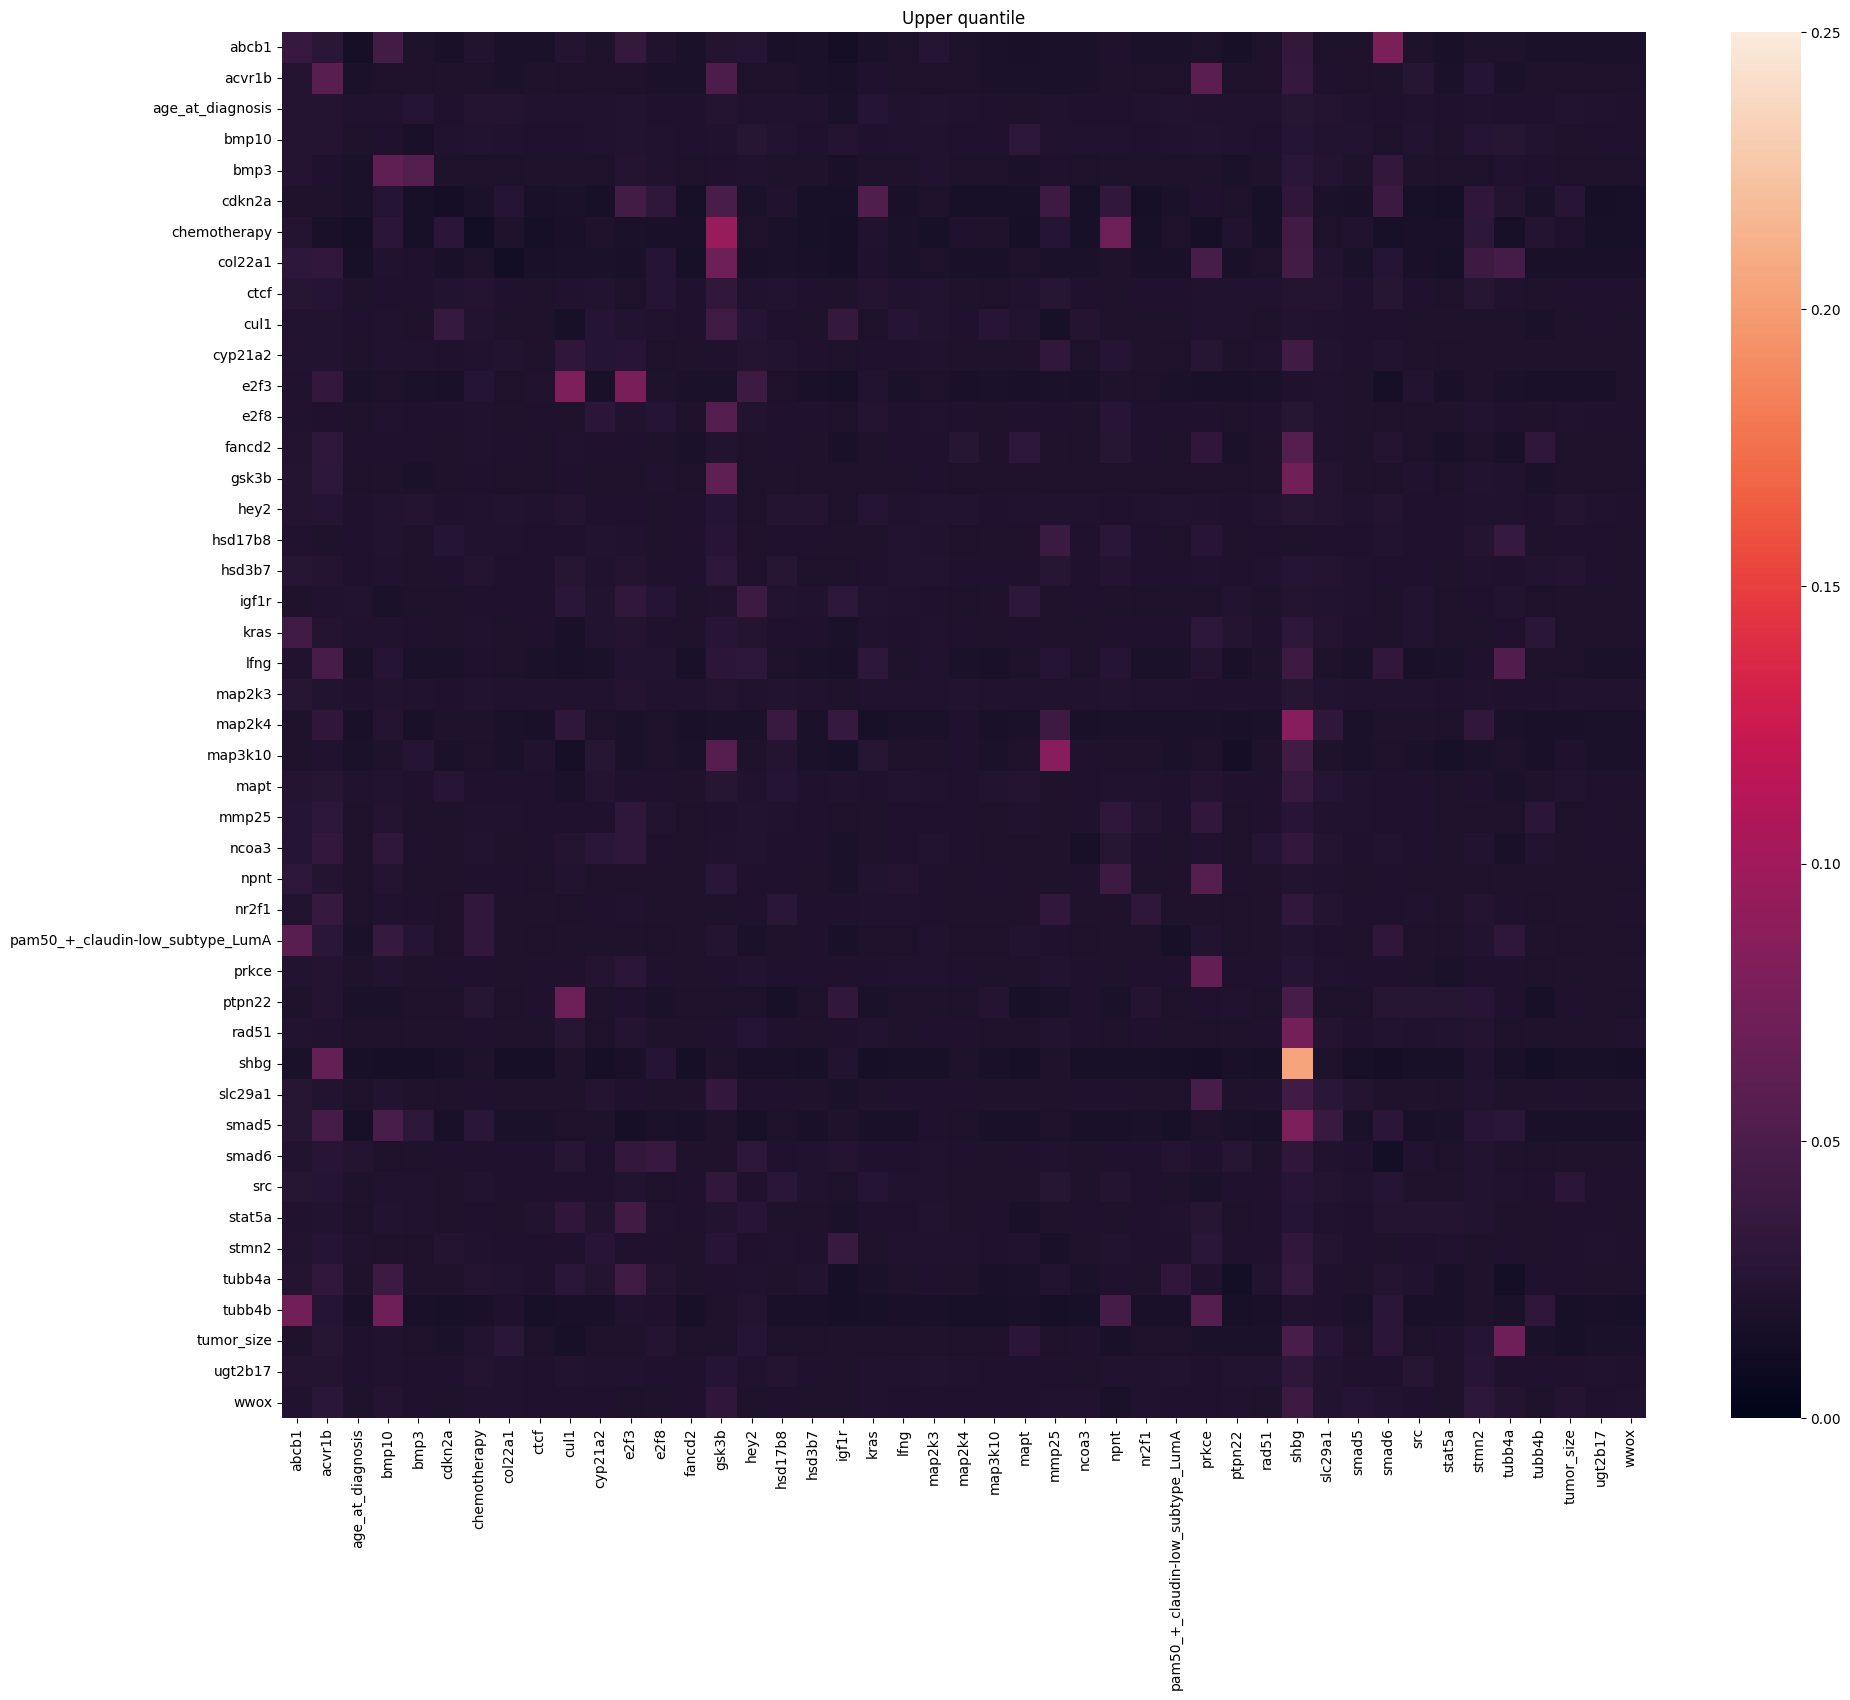

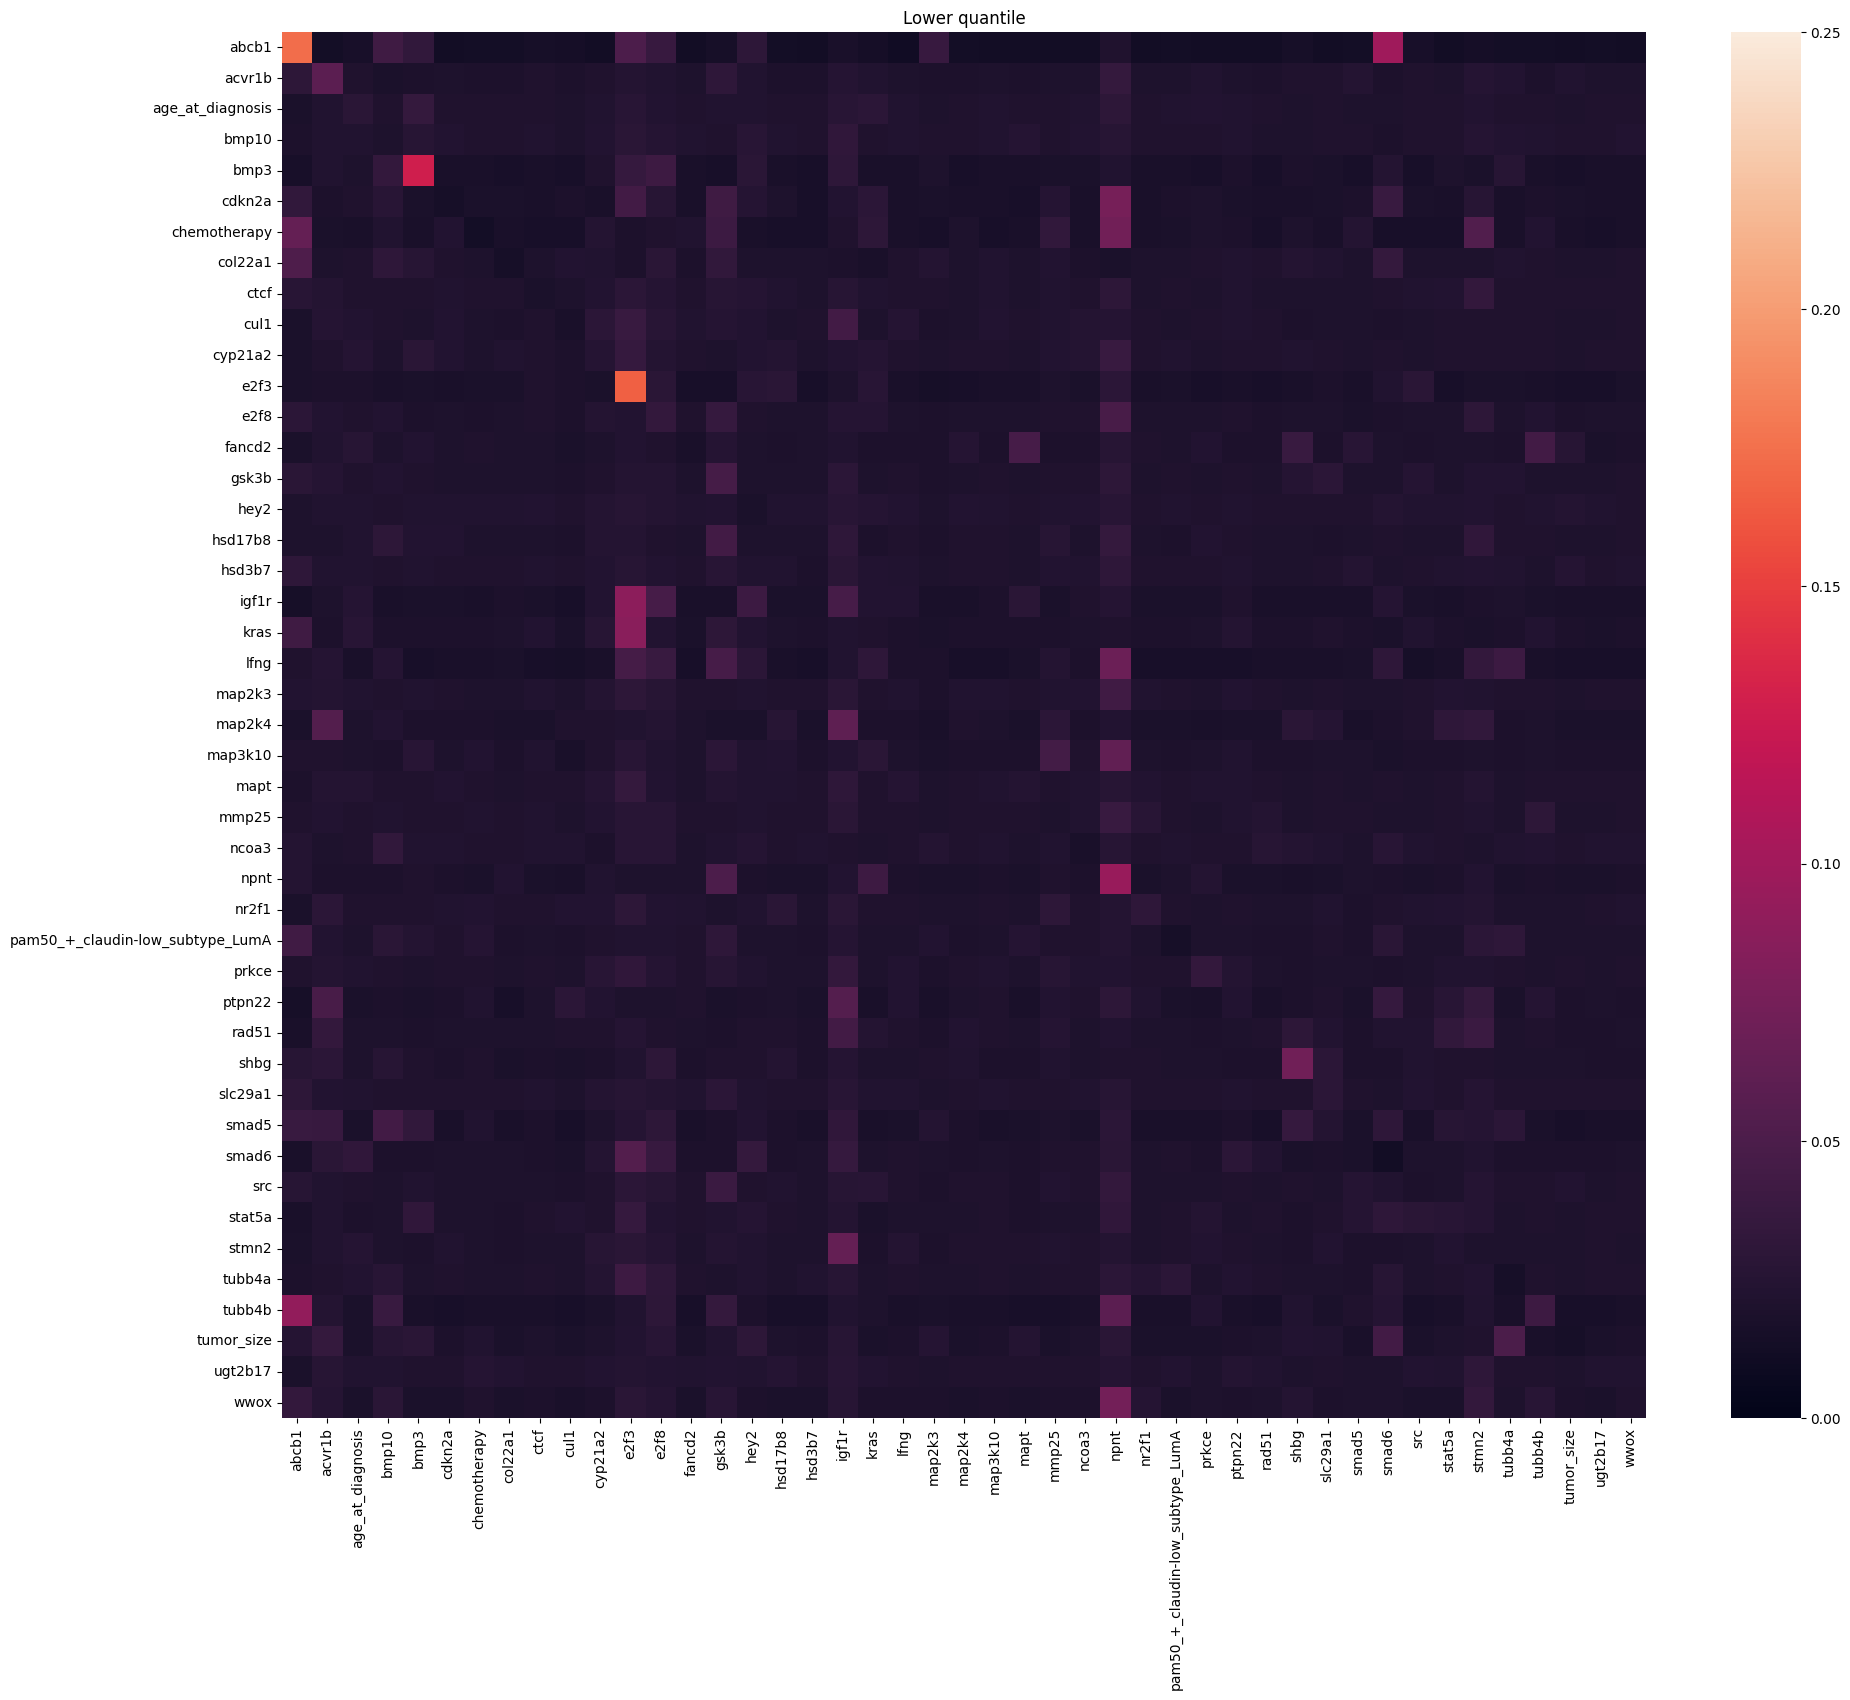

In [97]:
epoch = 19

plot_heatmaps(heatmaps_test_high[epoch], heatmaps_test_low[epoch], labels)

## Concordance index for different number of heads

{1: 0.6884863695304267, 2: 0.68564840538309, 4: 0.691720425017807, 8: 0.6856772848529973, 16: 0.6836343678007587}


<Axes: >

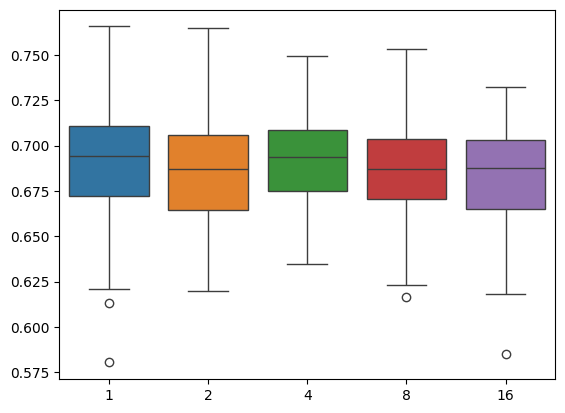

In [ ]:
mean = {}
for key, value in C_test_heads.items():
    mean[key] = np.mean(value)
print(mean)
sns.boxplot(C_test_heads)

## Brier score for different number of heads

{1: 0.17894532316729422, 2: 0.17889648933216848, 4: 0.17757727944765445, 8: 0.17804608842004999, 16: 0.17947711993238546}


<Axes: >

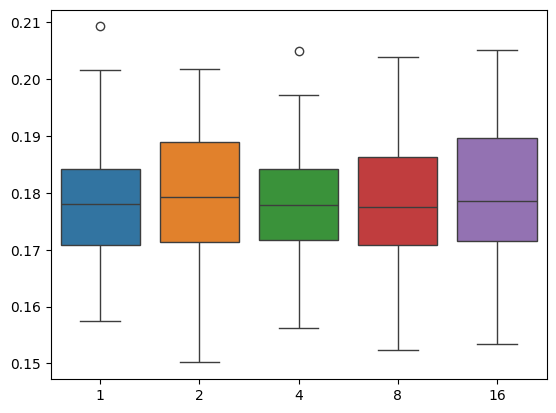

In [ ]:
mean = {}
for key, value in B_test_heads.items():
    mean[key] = np.mean(value)
print(mean)
sns.boxplot(B_test_heads)

In [ ]:
num_et = 10
num_heads=16

concordance_test, concordance_train, brier_test, _ = AttentionDeepCox(df_all, num_et, num_heads, categories)
C_test["Attention"]= np.array(concordance_test)
B_test["Attention"]= np.array(brier_test)


0:	[0s / 0s],		train_loss: 6.3825,	val_loss: 5.2959
1:	[0s / 0s],		train_loss: 5.2132,	val_loss: 4.8492
2:	[0s / 0s],		train_loss: 5.0964,	val_loss: 4.6986
3:	[0s / 0s],		train_loss: 4.9760,	val_loss: 4.6050
4:	[0s / 0s],		train_loss: 4.8833,	val_loss: 4.4776
5:	[0s / 0s],		train_loss: 4.8991,	val_loss: 4.4634
6:	[0s / 0s],		train_loss: 4.8538,	val_loss: 4.5614
7:	[0s / 0s],		train_loss: 4.7324,	val_loss: 4.6134
8:	[0s / 0s],		train_loss: 4.6948,	val_loss: 4.5766
9:	[0s / 0s],		train_loss: 4.6622,	val_loss: 4.5915
10:	[0s / 0s],		train_loss: 4.5720,	val_loss: 4.5671
11:	[0s / 0s],		train_loss: 4.5222,	val_loss: 4.6690
12:	[0s / 0s],		train_loss: 4.4721,	val_loss: 4.7118
13:	[0s / 0s],		train_loss: 4.4383,	val_loss: 4.9601
14:	[0s / 0s],		train_loss: 4.3638,	val_loss: 4.7962
15:	[0s / 0s],		train_loss: 4.3442,	val_loss: 4.9425
0:	[0s / 0s],		train_loss: 5.8772,	val_loss: 5.4820
1:	[0s / 0s],		train_loss: 5.0446,	val_loss: 4.6902
2:	[0s / 0s],		train_loss: 4.9346,	val_loss: 4.4048
3:	[0s

# Comparing performance of the three implemented models:

{'Base': 0.6182786469919297, 'Article': 0.6577666815889948, 'Attention': 0.670642162354902}


<Axes: >

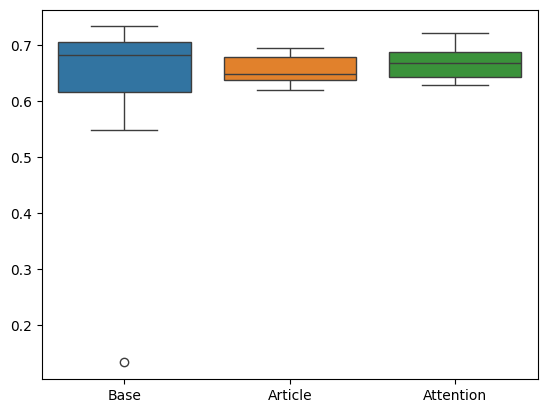

In [ ]:
mean = {}
for key, value in C_test.items():
    mean[key] = np.mean(value)
print(mean)
sns.boxplot(C_test)

{'Base': 0.17899071582438136, 'Article': 0.3586037427038538, 'Attention': 0.18474456891068342}


<Axes: >

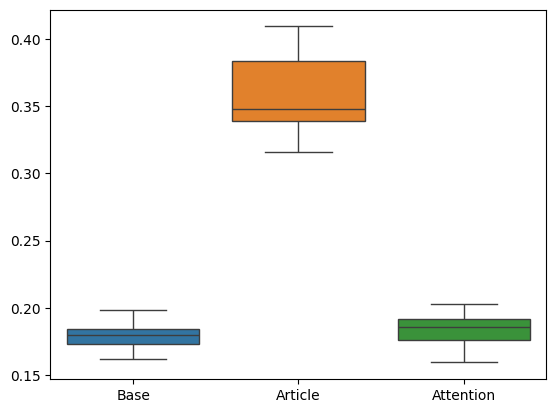

In [ ]:
mean = {}
for key, value in B_test.items():
    mean[key] = np.mean(value)
print(mean)
sns.boxplot(B_test)